# Initailization

In [2]:
!pip install pandas numpy matplotlib seaborn wordcloud transformers torch nltk dateparser

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.7/295.7 kB 18.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [3]:
import dateparser as dp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
import string
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.nn.functional import softmax
from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [5]:
#importing the data
reviews_df = pd.read_excel('Google_Reviews.xlsx')

reviews_df.head()

,Name,Ratings,review,time
0,Chen Z,"Rated 2.0 out of 5,Rated 2.0 out of 5,",This front building smells like fermented feces.|,3 days ago
1,Bigyan-12,"Rated 5.0 out of 5,Rated 5.0 out of 5,",Great|,3 days ago
2,Marcus,"Rated 3.0 out of 5,Rated 3.0 out of 5,",Nice new school but can someone to tell the du...,a week ago
3,kanwar danish,"Rated 5.0 out of 5,Rated 5.0 out of 5,",NaN,a week ago
4,Jeevan Duwal,"Rated 5.0 out of 5,Rated 5.0 out of 5,",NaN,3 weeks ago


# Data Cleaning

Tranforming the Ratings column from string to integer.

In [6]:
reviews_df['Ratings'].unique()

array(['Rated 2.0 out of 5,Rated 2.0 out of 5,',
       'Rated 5.0 out of 5,Rated 5.0 out of 5,',
       'Rated 3.0 out of 5,Rated 3.0 out of 5,',
       'Rated 1.0 out of 5,Rated 1.0 out of 5,',
       'Rated 4.0 out of 5,Rated 4.0 out of 5,'], dtype=object)

Since the Ratings column has a clear pattern, we just need to extract the first digit from each cell to as the rating given in the review.

In [7]:
# Extract numeric values and convert to integer
reviews_df['ratings_int'] = pd.to_numeric(reviews_df['Ratings'].str.extract('(\d+)', expand=False), errors='coerce')

# Display first few rows
reviews_df.head()

,Name,Ratings,review,time,ratings_int
0,Chen Z,"Rated 2.0 out of 5,Rated 2.0 out of 5,",This front building smells like fermented feces.|,3 days ago,2
1,Bigyan-12,"Rated 5.0 out of 5,Rated 5.0 out of 5,",Great|,3 days ago,5
2,Marcus,"Rated 3.0 out of 5,Rated 3.0 out of 5,",Nice new school but can someone to tell the du...,a week ago,3
3,kanwar danish,"Rated 5.0 out of 5,Rated 5.0 out of 5,",NaN,a week ago,5
4,Jeevan Duwal,"Rated 5.0 out of 5,Rated 5.0 out of 5,",NaN,3 weeks ago,5


Next we convert the time column from string to actual date relative to the date when the data was scraped (02/06/2025)

In [8]:
reviews_df['time'].unique()

array(['3 days ago', 'a week ago', '3 weeks ago', '4 weeks ago',
       'a month ago', '2 months ago', '3 months ago', '4 months ago',
       '5 months ago', '6 months ago', '7 months ago', '8 months ago',
       '9 months ago', '10 months ago', '11 months ago', 'a year ago',
       '2 years ago', '3 years ago', '4 years ago', '5 years ago',
       '6 years ago', '7 years ago', '8 years ago', '9 years ago',
       '10 years ago', '11 years ago', '12 years ago', '13 years ago'],
      dtype=object)

Since the time column contains values relative to (02/06/2025). We will use the dateparser library to change the relative time strings into datetime values

In [9]:
#defining a function to take time column as input,
#set the reference data,
# and change the string relative to the reference date
#to return a datetime object

def con_dt(time_str):
  ref_date = pd.to_datetime('02/06/2025',format = '%m/%d/%Y') #setting the ref date
  act_date = dp.parse(time_str,settings={'RELATIVE_BASE':ref_date}) #changind the string value relative to ref date
  return act_date

In [10]:
#applying the function to the time column
reviews_df['date'] = reviews_df['time'].apply(con_dt)

reviews_df.head()

,Name,Ratings,review,time,ratings_int,date
0,Chen Z,"Rated 2.0 out of 5,Rated 2.0 out of 5,",This front building smells like fermented feces.|,3 days ago,2,2025-02-03
1,Bigyan-12,"Rated 5.0 out of 5,Rated 5.0 out of 5,",Great|,3 days ago,5,2025-02-03
2,Marcus,"Rated 3.0 out of 5,Rated 3.0 out of 5,",Nice new school but can someone to tell the du...,a week ago,3,2025-01-30
3,kanwar danish,"Rated 5.0 out of 5,Rated 5.0 out of 5,",NaN,a week ago,5,2025-01-30
4,Jeevan Duwal,"Rated 5.0 out of 5,Rated 5.0 out of 5,",NaN,3 weeks ago,5,2025-01-16


In [11]:
#drop the Ratings and time column
reviews_df = reviews_df.drop(['Ratings', 'time'], axis=1)

reviews_df.head()

,Name,review,ratings_int,date
0,Chen Z,This front building smells like fermented feces.|,2,2025-02-03
1,Bigyan-12,Great|,5,2025-02-03
2,Marcus,Nice new school but can someone to tell the du...,3,2025-01-30
3,kanwar danish,NaN,5,2025-01-30
4,Jeevan Duwal,NaN,5,2025-01-16


We need to add a ID column as a unique Identifier for each row and drop the name column to maintain anonymity

In [12]:
num_rows = len(reviews_df) #gives no of rows in our dataset

id_values = range(1, num_rows+1) #gives a sequence of numbers equal to the size of our dataset


In [13]:
# add the id values to the dataset as the first column
reviews_df.insert(0, 'ID', id_values)

reviews_df.head()

,ID,Name,review,ratings_int,date
0,1,Chen Z,This front building smells like fermented feces.|,2,2025-02-03
1,2,Bigyan-12,Great|,5,2025-02-03
2,3,Marcus,Nice new school but can someone to tell the du...,3,2025-01-30
3,4,kanwar danish,NaN,5,2025-01-30
4,5,Jeevan Duwal,NaN,5,2025-01-16


In [14]:
#drop the Name column
reviews_df = reviews_df.drop('Name', axis=1)

reviews_df.head()

,ID,review,ratings_int,date
0,1,This front building smells like fermented feces.|,2,2025-02-03
1,2,Great|,5,2025-02-03
2,3,Nice new school but can someone to tell the du...,3,2025-01-30
3,4,NaN,5,2025-01-30
4,5,NaN,5,2025-01-16


In [15]:
# Remove "|" from reviews
reviews_df['review'] = reviews_df['review'].str.rstrip('|')

# Display first few rows
reviews_df.head()

,ID,review,ratings_int,date
0,1,This front building smells like fermented feces.,2,2025-02-03
1,2,Great,5,2025-02-03
2,3,Nice new school but can someone to tell the du...,3,2025-01-30
3,4,NaN,5,2025-01-30
4,5,NaN,5,2025-01-16


In [16]:
# Download stopwords
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

# Function to clean text
def clean_text(text):
    if isinstance(text, str):  # Check if the text is a string
        text = text.lower()  # Convert to lowercase
        text = text.translate(str.maketrans("", "", string.punctuation))  # Remove punctuation
        words = text.split()
        words = [word for word in words if word not in stop_words]  # Remove stopwords
        return " ".join(words)
    return ""  # Return empty string if text is not a valid string

# Apply cleaning function
reviews_df["cleaned_review"] = reviews_df["review"].apply(clean_text)

# Display cleaned text
reviews_df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,ID,review,ratings_int,date,cleaned_review
0,1,This front building smells like fermented feces.,2,2025-02-03,front building smells like fermented feces
1,2,Great,5,2025-02-03,great
2,3,Nice new school but can someone to tell the du...,3,2025-01-30,nice new school someone tell dudes stop pissin...
3,4,NaN,5,2025-01-30,
4,5,NaN,5,2025-01-16,


Converts text to lowercase to maintain uniformity.
Removes punctuation (e.g., !?,.).
Removes stopwords (common words like "the", "is", "and") to focus on meaningful words.

In [17]:
# Combine all reviews
text = " ".join(reviews_df["cleaned_review"])

# EDA

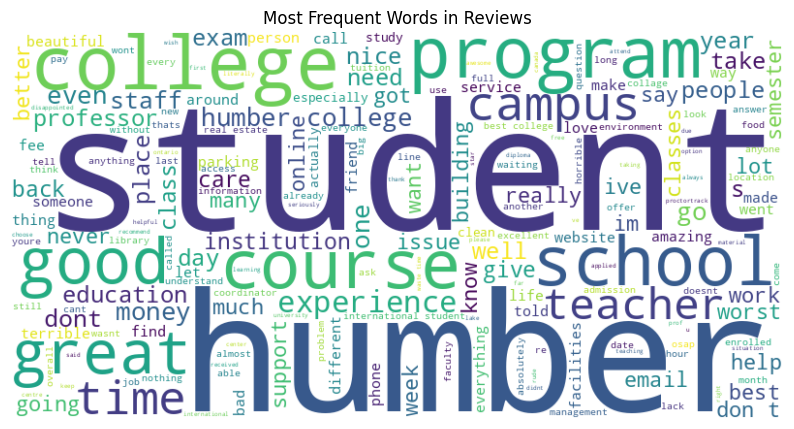

In [18]:
# Generate word cloud
plt.figure(figsize=(10, 6))
wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="viridis").generate(text)

# Show word cloud
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Frequent Words in Reviews")
plt.show()

This word cloud provides a visual representation of the most frequent words in the reviews, which can be insightful for identifying general themes and sentiments. For example:

Key Themes: Words like "student," "program," "college," "school," and "course" are prominent, indicating that the reviews are focused on these core aspects of the academic experience.

Positive Sentiments: Words like "great," "good," "nice," "amazing," and "love" suggest positive experiences related to specific elements.

Negative Sentiments: Words like "issue," "worst," "bad," and "problem" point to areas where dissatisfaction or challenges are being highlighted.

Recurrent Topics: Words such as "campus," "teacher," "service," "time," and "staff" likely reflect common areas of discussion, whether positive or negative.

Insights for Improvement: The prominence of words like "help," "support," "care," and "email" might indicate areas where students frequently seek assistance or where there might be service gaps.

<ipython-input-19-4e13338f24ef>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=reviews_df['ratings_int'], palette="coolwarm")


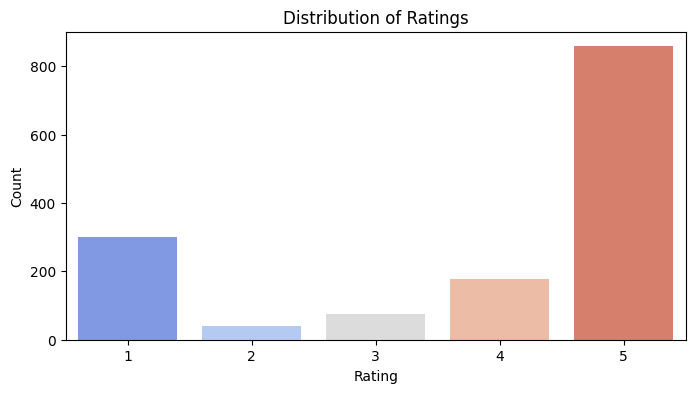

In [19]:
# Visualizing distribution of ratings
plt.figure(figsize=(8,4))
sns.countplot(x=reviews_df['ratings_int'], palette="coolwarm")
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

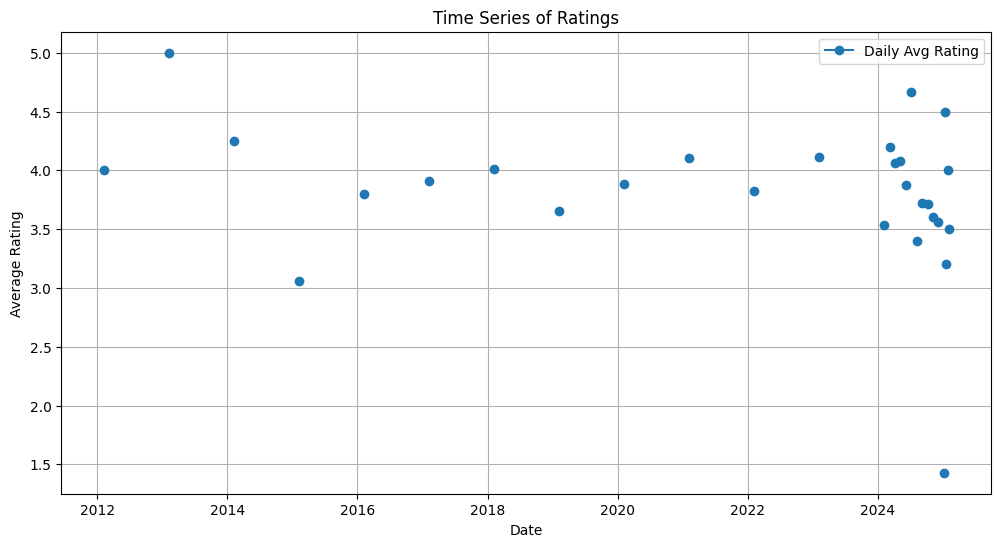

In [20]:
# Ensure 'date_column' is in datetime format
reviews_df['date'] = pd.to_datetime(reviews_df['date'], errors='coerce')

# Drop rows where date conversion failed (NaT values)
reviews_df.dropna(subset=['date'], inplace=True)

# Set the datetime column as the index
reviews_df.set_index('date', inplace=True)

# Ensure 'ratings_int' is numeric
reviews_df['ratings_int'] = pd.to_numeric(reviews_df['ratings_int'], errors='coerce')
reviews_df.dropna(subset=['ratings_int'], inplace=True)  # Drop rows with NaN ratings

# Resample the data to get daily average ratings
reviews_df_resampled = reviews_df[['ratings_int']].resample('D').mean()  # 'D' = daily, 'W' = weekly

# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(reviews_df_resampled.index, reviews_df_resampled['ratings_int'], marker='o', linestyle='-', label='Daily Avg Rating')
plt.xlabel('Date')
plt.ylabel('Average Rating')
plt.title('Time Series of Ratings')
plt.legend()
plt.grid(True)
plt.show()

# Sentiment Analysis

In [21]:
# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
model = BertForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/669M [00:00<?, ?B/s]

BERT (Bidirectional Encoder Representations from Transformers) is used for sentiment classification.
The pretrained model can classify sentiment on a 1-5 scale.

In [22]:
def predict_sentiment(text):
    tokens = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    output = model(**tokens)
    scores = softmax(output.logits, dim=1).detach().numpy()
    sentiment_score = np.argmax(scores) + 1  # Convert to 1-5 scale
    return sentiment_score

# Apply sentiment prediction only to rows where 'cleaned_review' is not NaN or empty
reviews_df["predicted_sentiment"] = reviews_df["cleaned_review"].apply(
    lambda x: predict_sentiment(x) if pd.notnull(x) and x != "" else np.nan
)

# Display sample results
reviews_df[["review", "predicted_sentiment"]].head()

,review,predicted_sentiment
date,,
2025-02-03,This front building smells like fermented feces.,1.0
2025-02-03,Great,5.0
2025-01-30,Nice new school but can someone to tell the du...,4.0
2025-01-30,NaN,NaN
2025-01-16,NaN,NaN


Tokenizes the text and passes it through BERT.
Predicts sentiment scores between 1 (negative) to 5 (positive).
Stores sentiment scores in a new column predicted_sentiment.

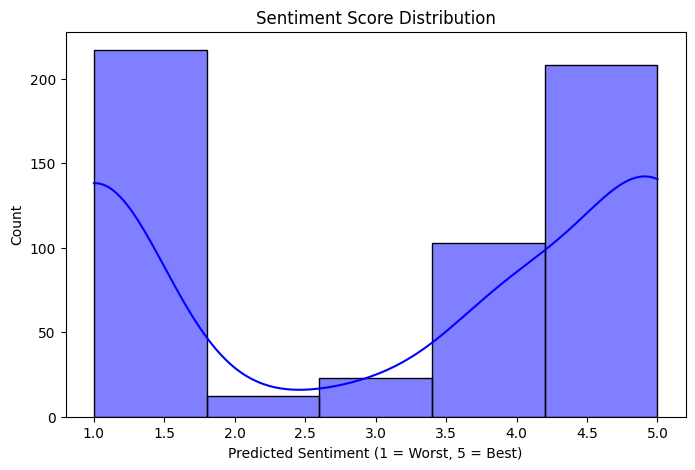

In [23]:
# Visualize predicted sentiment distribution
plt.figure(figsize=(8, 5))
sns.histplot(reviews_df["predicted_sentiment"], bins=5, kde=True, color="blue")
plt.xlabel("Predicted Sentiment (1 = Worst, 5 = Best)")
plt.ylabel("Count")
plt.title("Sentiment Score Distribution")
plt.show()

The histogram reveals a bimodal distribution of sentiment scores, with prominent peaks at 1.0 (indicating negative sentiments) and 5.0 (indicating positive sentiments), while scores in the middle range (2.0–3.5) occur much less frequently. This pattern suggests that reviews are highly polarized, with most being either strongly positive or strongly negative. The slight skew towards higher scores indicates a generally positive sentiment trend. The distribution highlights potential areas for deeper analysis, such as exploring the factors driving extreme sentiments and examining the context behind the less frequent neutral scores.

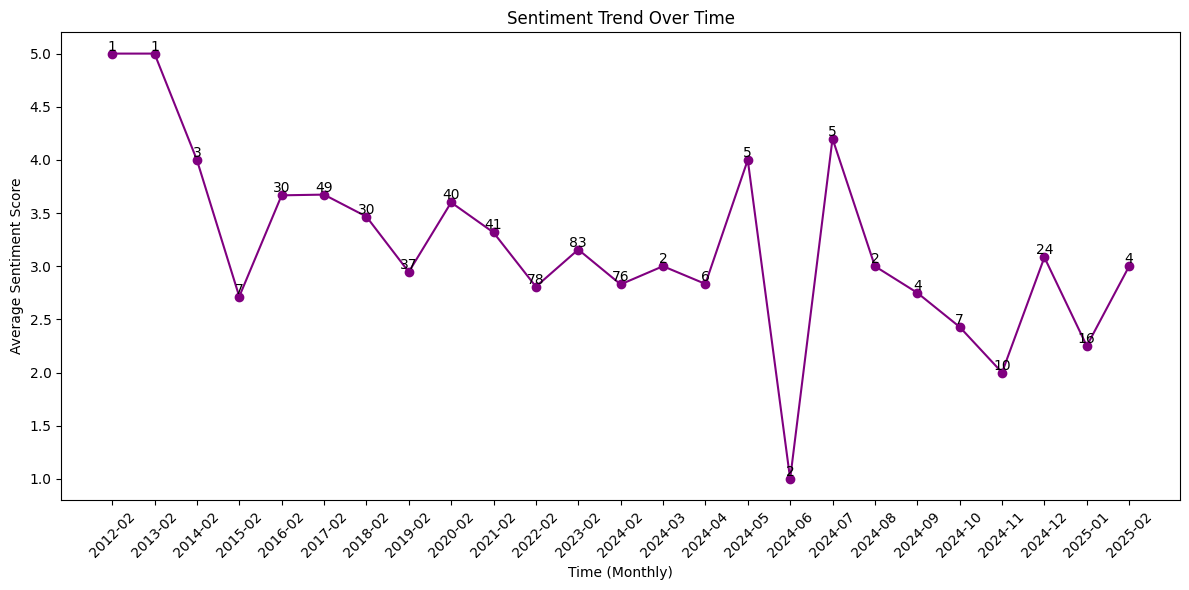

In [24]:
reviews_df = reviews_df.reset_index()  # Moves 'date' from index to a regular column
# Aggregate sentiment scores and counts over time
reviews_df_time = reviews_df.groupby(reviews_df["date"].dt.to_period("M")).agg(
    average_sentiment=("predicted_sentiment", "mean"),
    review_count=("predicted_sentiment", "count")
).reset_index()


# Convert 'date' back to a string for plotting
reviews_df_time["date"] = reviews_df_time["date"].astype(str)

# Plot sentiment trend over time
plt.figure(figsize=(12, 6))
plt.plot(
    reviews_df_time["date"],
    reviews_df_time["average_sentiment"],
    marker="o",
    linestyle="-",
    color="purple"
)
plt.xlabel("Time (Monthly)")
plt.ylabel("Average Sentiment Score")
plt.title("Sentiment Trend Over Time")

# Annotate each data point with the review count
for i, (date, sentiment, count) in enumerate(zip(reviews_df_time["date"], reviews_df_time["average_sentiment"], reviews_df_time["review_count"])):
    plt.text(
        i, sentiment,  # Position of the annotation
        f"{count}",  # Text (review count)
        fontsize=10, ha="center", va="bottom", color="black"
    )

# Adjust x-axis labels
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The sentiment trend over time reveals periods of stability and sharp fluctuations. Sentiment stabilizes between 3–4 from 2016 to 2023, supported by consistent review counts (30–83), making this period more representative. Sharp dips and rebounds, such as in mid-2024, coincide with very low review counts (2–5) and should be interpreted cautiously. Periods of extreme sentiment shifts, even with low review counts, may indicate critical feedback or significant events like product issues or successful campaigns. Investigating these fluctuations and mapping them to external events can help identify root causes, address problems, and replicate positive outcomes to enhance customer satisfaction.

<ipython-input-25-606a8ca2de51>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["true_class"] = pd.cut(filtered_df["ratings_int"], bins=bins, labels=labels, include_lowest=True)
<ipython-input-25-606a8ca2de51>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["predicted_class"] = pd.cut(filtered_df["predicted_sentiment"], bins=bins, labels=labels, include_lowest=True)


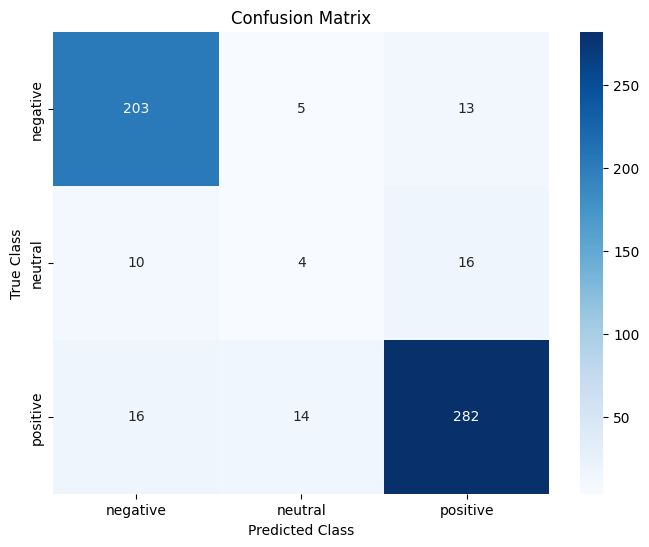

Classification Report:
              precision    recall  f1-score   support

    negative       0.89      0.92      0.90       221
     neutral       0.17      0.13      0.15        30
    positive       0.91      0.90      0.91       312

    accuracy                           0.87       563
   macro avg       0.66      0.65      0.65       563
weighted avg       0.86      0.87      0.86       563

Accuracy: 0.87


In [25]:
# Ensure numeric values and handle NaN
reviews_df["ratings_int"] = pd.to_numeric(reviews_df["ratings_int"], errors="coerce")
reviews_df["predicted_sentiment"] = pd.to_numeric(reviews_df["predicted_sentiment"], errors="coerce")

# Filter out rows with NaN values temporarily for calculations
filtered_df = reviews_df.dropna(subset=["ratings_int", "predicted_sentiment"])

# Bin numeric ratings into sentiment categories
bins = [0, 2.5, 3.5, 5]  # Define boundaries for negative, neutral, positive
labels = ["negative", "neutral", "positive"]

# Apply binning to the filtered DataFrame
filtered_df["true_class"] = pd.cut(filtered_df["ratings_int"], bins=bins, labels=labels, include_lowest=True)
filtered_df["predicted_class"] = pd.cut(filtered_df["predicted_sentiment"], bins=bins, labels=labels, include_lowest=True)

# Confusion matrix
conf_matrix = confusion_matrix(filtered_df["true_class"], filtered_df["predicted_class"], labels=labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix")
plt.show()

# Classification metrics
print("Classification Report:")
print(classification_report(filtered_df["true_class"], filtered_df["predicted_class"], target_names=labels))

# Accuracy
accuracy = accuracy_score(filtered_df["true_class"], filtered_df["predicted_class"])
print(f"Accuracy: {accuracy:.2f}")


The model demonstrates an overall accuracy of 87%, indicating that it correctly classifies 87% of reviews into their respective sentiment categories, which is a strong result. It performs exceptionally well for the negative class (Precision: 0.89, Recall: 0.92, F1-Score: 0.90) and the positive class (Precision: 0.91, Recall: 0.90, F1-Score: 0.91), but struggles significantly with the neutral class (Precision: 0.17, Recall: 0.13, F1-Score: 0.15). This disparity is largely due to the inherent difficulty in distinguishing neutral reviews, which often overlap with positive or negative sentiments, as well as the pronounced class imbalance—only 30 neutral reviews compared to 312 positive and 221 negative ones. The poor performance on neutral reviews highlights the need for techniques to address class imbalance, such as oversampling or undersampling, or using class weights during training.

Moreover, the macro averages (Precision: 0.66, Recall: 0.65, F1-Score: 0.65) reflect the equal consideration of all classes, showing weaker performance due to the struggles with neutral reviews. In contrast, the weighted averages (Precision: 0.86–0.87) better align with overall accuracy by accounting for class imbalance, emphasizing the model's focus on the dominant positive and negative classes.

Given that this dataset consists of real Google reviews, it’s evident that individuals with strong positive or negative opinions are more likely to leave reviews, resulting in an incomplete picture. Encouraging a broader range of customers—including those with neutral opinions—to share their feedback could create a more balanced and representative dataset, enhancing the model’s ability to provide meaningful insights.

Topic modeling on positive and negative reviews is done using TF-IDF vectorization and Latent Dirichlet Allocation (LDA). It extracts the most relevant themes by identifying top keywords for a specified number of topics. By analyzing reviews separately by sentiment, the approach uncovers key themes in customer feedback, highlighting common issues or praises to guide business decisions and improve customer experience.

In [26]:
# Ensure the cleaned column is used for analysis
if "cleaned_review" not in filtered_df.columns:
    print("The column 'cleaned_review' does not exist in your DataFrame. Please check the preprocessing step.")
else:
    # Use the cleaned text for analysis
    positive_reviews = " ".join(
        filtered_df.loc[filtered_df["true_class"] == "positive", "cleaned_review"].dropna()
    )
    neutral_reviews = " ".join(
        filtered_df.loc[filtered_df["true_class"] == "neutral", "cleaned_review"].dropna()
    )
    negative_reviews = " ".join(
        filtered_df.loc[filtered_df["true_class"] == "negative", "cleaned_review"].dropna()
    )

In [27]:
def get_topics(text_list, num_topics=3, num_words=10):
    vectorizer = TfidfVectorizer(stop_words="english")
    X = vectorizer.fit_transform(text_list)

    lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    lda.fit(X)

    words = vectorizer.get_feature_names_out()
    for i, topic in enumerate(lda.components_):
        print(f"Topic {i+1}: {[words[i] for i in topic.argsort()[-num_words:]]}")

print("Negative Review Topics:")
get_topics(negative_reviews.split())

print("Positive Review Topics:")
get_topics(positive_reviews.split())

Negative Review Topics:
Topic 1: ['education', 'student', 'class', 'staff', 'worst', 'care', 'dont', 'course', 'school', 'humber']
Topic 2: ['terrible', 'professors', 'say', 'support', 'classes', 'international', 'waste', 'people', 'exam', 'money']
Topic 3: ['campus', 'don', 'better', 'experience', 'like', 'teachers', 'time', 'program', 'college', 'students']
Positive Review Topics:
Topic 1: ['course', 'library', 'programs', 'collage', 'professors', 'education', 'staff', 'students', 'program', 'college']
Topic 2: ['building', 'love', 'beautiful', 'time', 'study', 'experience', 'best', 'campus', 'humber', 'great']
Topic 3: ['lots', 'excellent', 'north', 'clean', 'facilities', 'amazing', 'place', 'school', 'nice', 'good']


Negative reviews highlight dissatisfaction with academic quality, student support, and administrative services. Students express frustration with professors, course structure, and lack of guidance, especially for international students. Additionally, concerns about tuition value and poor responsiveness from staff contribute to a sense of neglect. Complaints about the campus experience suggest that some students feel the programs and overall learning environment need improvement.

In contrast, positive reviews emphasize strengths in campus infrastructure, library resources, and well-maintained facilities. Students appreciate the beautiful campus, study spaces, and educational resources, indicating that the physical environment enhances their experience. The clean and well-organized facilities also contribute to positive sentiments.

Overall, while students value the campus and resources, dissatisfaction with teaching quality and student support affects their experience. Addressing faculty engagement, administrative support, and value-for-money concerns could significantly improve student satisfaction.

The code below identifies the most frequently occurring n-grams (specifically bigrams) in positive, neutral, and negative reviews, expressed as percentages of the total bigrams in the dataset. It uses the CountVectorizer to extract bigram counts and calculates their relative frequency. The results highlight commonly paired words in each sentiment category, providing insights into recurring phrases that characterize positive, neutral, or negative customer feedback

In [28]:
def get_top_ngrams(text_list, n=2, top_n=10):
    vectorizer = CountVectorizer(ngram_range=(n, n))
    X = vectorizer.fit_transform(text_list)  # Expecting list of full documents
    ngram_counts = X.toarray().sum(axis=0)

    total_ngrams = sum(ngram_counts)  # Total bigrams for percentage calculation
    ngram_freq = {
        ngram: round((count / total_ngrams) * 100, 2)  # Rounded to 2 decimal places
        for ngram, count in zip(vectorizer.get_feature_names_out(), ngram_counts)
    }

    return sorted(ngram_freq.items(), key=lambda x: x[1], reverse=True)[:top_n]

# Get top bigrams (as percentages) for each sentiment
print("Top bigrams in Positive Reviews:", get_top_ngrams([positive_reviews], n=2))
print("Top bigrams in Neutral Reviews:", get_top_ngrams([neutral_reviews], n=2))
print("Top bigrams in Negative Reviews:", get_top_ngrams([negative_reviews], n=2))

Top bigrams in Positive Reviews: [('humber college', 0.68), ('best college', 0.37), ('great college', 0.31), ('one best', 0.29), ('north campus', 0.24), ('place study', 0.24), ('great school', 0.21), ('college north', 0.18), ('campus great', 0.13), ('college experience', 0.13)]
Top bigrams in Neutral Reviews: [('like dont', 0.8), ('sweaty smelly', 0.8), ('dont get', 0.6), ('cmon youre', 0.4), ('dont go', 0.4), ('dudes stop', 0.4), ('even good', 0.4), ('get sweaty', 0.4), ('go humber', 0.4), ('good postsecondary', 0.4)]
Top bigrams in Negative Reviews: [('humber college', 0.39), ('real estate', 0.15), ('international students', 0.14), ('waste time', 0.14), ('care students', 0.12), ('waste money', 0.12), ('worst college', 0.12), ('dont waste', 0.1), ('even though', 0.1), ('time money', 0.1)]


Positive reviews highlight Humber College’s strong reputation, with students frequently describing it as the “best” or “great” college. Appreciation for the campus environment and study spaces, especially at North Campus, is evident.

Neutral reviews contain mixed and informal complaints, with phrases indicating mild frustrations or sarcastic tones. Some comments suggest indifference toward education quality, while others mention minor inconveniences like cleanliness.

Negative reviews focus on concerns about education quality, financial value, and student support. Some students feel their time and money were wasted, while international students express dissatisfaction with support services. Criticism is often directly tied to Humber College’s brand, impacting its reputation.